<a href="https://colab.research.google.com/github/Abir702/fake-news-detection-ml/blob/main/FakeNewsDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Before running the commands please downnload and upload True and Fake news datasets in .csv format.
# Important :- RUN EACH PART OF THE CODE ONE BY ONE PLEASE.
!pip install nltk scikit-learn pandas
!pip install gensim
!pip install --upgrade numpy
!pip install --upgrade gensim
!pip install --force-reinstall gensim
!pip install textblob
!pip install wordcloud imbalanced-learn

# Restart the kernel after running the above commands.
# This ensures the changes are reflected in your environment.

  Using cached gensim-4.4.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (8.4 kB)
  Using cached numpy-2.4.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached smart_open-7.5.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-2.0.1-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl.metadata (9.0 kB)
Using cached gensim-4.4.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (27.9 MB)
Using cached numpy-2.4.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.4 MB)
Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (35.0 MB)
Using cached smart_open-7.5.0-py3-none-any.whl (63 kB)
Using cached wrapt-2.0.1-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl (121 kB)
  Attempting uninstall: wrapt
    Found exi

In [1]:
!pip install kaggle --quiet



In [2]:
import os

# Set your own Kaggle username and API key here
os.environ['KAGGLE_USERNAME'] = 'YOUR_KAGGLE_USERNAME'
os.environ['KAGGLE_KEY'] = 'YOUR_KAGGLE_KEY'


In [3]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip -q fake-and-real-news-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
import string
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download stopwords and Word2Vec model (only once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
wv = api.load('word2vec-google-news-300')  # Load pre-trained Word2Vec model

# Load the dataset
fake_data = pd.read_csv('Fake.csv')
fake_data['label'] = 0
true_data = pd.read_csv('True.csv')
true_data['label'] = 1

# Concatenate fake and true dataframes
data = pd.concat([fake_data, true_data], ignore_index=True)

# Select only the text and label columns
data = data[['text', 'label']]

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # 1. Lowercase the text
    text = text.lower()

    # 2. Spelling correction
    text = str(TextBlob(text).correct())

    # 3. Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # 4. Tokenize
    tokens = text.split()

    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 6. Lemmatize and Stem
    tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens]

    # 7. Join back into a string
    return ' '.join(tokens)

# Preprocessing function
def preprocess(text):
    text = text.lower()  # lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return ' '.join(tokens)

# Apply preprocessing
data['text'] = data['text'].apply(preprocess)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Feature extraction using Word2Vec
def get_word_embedding(text):
    """Gets the average Word2Vec embedding for a text."""
    words = text.split()
    embeddings = [wv[word] for word in words if word in wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return [0] * 300  # Return a zero vector if no words are found in Word2Vec

X_train_vec = [get_word_embedding(text) for text in X_train]
X_test_vec = [get_word_embedding(text) for text in X_test]

# Data balancing using SMOTE
smote = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

# Train model
model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
model.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred) # Calculate precision
recall = recall_score(y_test, y_pred)       # Calculate recall
f1 = f1_score(y_test, y_pred)             # Calculate F1-score


# Prediction function
def predict_news(news_text, model):
    """
    Predicts whether a news article is true or fake.

    Args:
        news_text (str): The text content of the news article.
        model (LogisticRegression): The trained logistic regression model.

    Returns:
        int: 0 if the news is predicted to be fake, 1 if true.
    """
    # Preprocess the news text
    preprocessed_text = preprocess(news_text)

    # Get Word2Vec embedding
    vectorized_text = get_word_embedding(preprocessed_text)

    # Make a prediction
    prediction = model.predict([vectorized_text])[0]  # Note: predict expects a 2D array

    return prediction



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


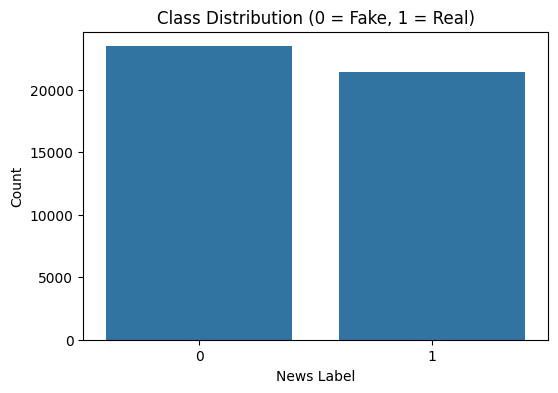

In [5]:
# 📊 Plot class distribution before SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data)
plt.title("Class Distribution (0 = Fake, 1 = Real)")
plt.xlabel("News Label")
plt.ylabel("Count")
plt.show()

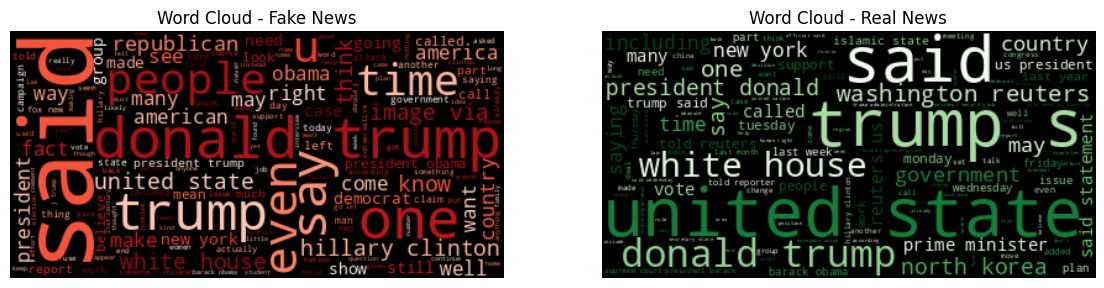

In [6]:
# 🌥️ Generate word clouds
fake_text = ' '.join(data[data['label'] == 0]['text'].values)
real_text = ' '.join(data[data['label'] == 1]['text'].values)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
wc_fake = WordCloud(max_words=200, background_color="black", colormap='Reds').generate(fake_text)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Fake News")

plt.subplot(1, 2, 2)
wc_real = WordCloud(max_words=200, background_color="black", colormap='Greens').generate(real_text)
plt.imshow(wc_real, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Real News")
plt.show()

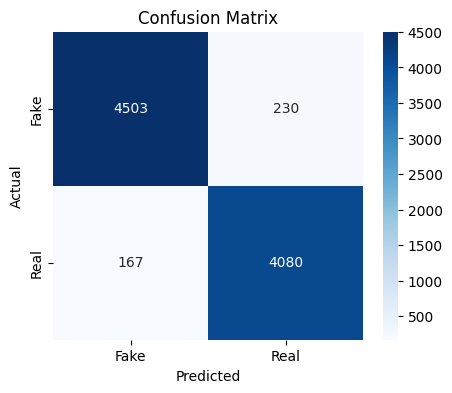

In [7]:
# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [8]:
# Model's Accuracy,Precision,F1-Score and Recall
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Accuracy: 95.58%
Precision: 94.66%
Recall: 96.07%
F1-Score: 95.36%


In [9]:
def predict_news(news_text, model):
    preprocessed_text = preprocess(news_text)
    vectorized_text = get_word_embedding(preprocessed_text)

    # Get probabilities instead of hard class label
    probabilities = model.predict_proba([vectorized_text])[0]

    prediction = model.predict([vectorized_text])[0]

    print(f"Prediction: {'Real' if prediction == 1 else 'Fake'}")
    print(f"Confidence → Fake: {probabilities[0]*100:.2f}%, Real: {probabilities[1]*100:.2f}%")

    return prediction

    # Test a fake article
news_article = "A Fargo, North Dakota, man was arrested for clearing snow with a flamethrower."
predict_news(news_article, model)



Prediction: Fake
Confidence → Fake: 99.55%, Real: 0.45%


np.int64(0)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test data
y_pred = model.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)


Accuracy:  0.9557906458797327
Precision:  0.9466357308584686
Recall:  0.9606781257358136
F1-Score:  0.9536052354797242


***NOTE :- The dataset is limited so the predictions of the model might vary and might not met to the expectattions.***







